# Deep Reinforcement Learning Laboratory

In this laboratory session we will work on getting more advanced versions of Deep Reinforcement Learning algorithms up and running. Deep Reinforcement Learning is **hard**, and getting agents to stably train can be frustrating and requires quite a bit of subtlety in analysis of intermediate results. We will start by refactoring (a bit) my implementation of `REINFORCE` on the [Cartpole environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/).

## Exercise 1: Improving my `REINFORCE` Implementation (warm up)

In this exercise we will refactor a bit and improve some aspects of my `REINFORCE` implementation.

**First Things First**: Spend some time playing with the environment to make sure you understand how it works.

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Instantiate a rendering and a non-rendering environment.
env_render = gym.make('CartPole-v1', render_mode='human')
env = gym.make('CartPole-v1')

# Plus one non standard one -- we need this to sample from policies.
from torch.distributions import Categorical

# Using Tensorboard.
from torch.utils.tensorboard import SummaryWriter

In [ ]:
# Your code here. Call .reset() on the environment and inspect the output. Also, check out the observation_space.

# env.reset() gives us the initial state and extra "info".
(s0, info) = env.reset()

# Observation space tells us the dimensions and limits of X.
print(f'X: {env.observation_space}')

# Action spate
print(f'A: {env.action_space}')

X: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
A: Discrete(2)


**Next Things Next**: Now get your `REINFORCE` implementation working on the environment. You can import my (probably buggy and definitely inefficient) implementation here. Or even better, refactor an implementation into a separate package from which you can `import` the stuff you need here.

**First**: All of the utility functions for selecting actions and running episodes.

In [ ]:
# Given an environment, observation, and policy, sample from pi(a | obs). Returns the
# selected action and the log probability of that action (needed for policy gradient).
def select_action(obs, policy):
    (probs, value) = policy(obs)
    dist = Categorical(probs)
    action = dist.sample()
    log_prob = dist.log_prob(action)
    return (action.item(), log_prob.reshape(1), value)

# Utility to compute the discounted total reward. Torch doesn't like flipped arrays, so we need to
# .copy() the final numpy array. There's probably a better way to do this.
def compute_returns(rewards, gamma):
    return np.flip(np.cumsum([gamma**(i+1)*r for (i, r) in enumerate(rewards)][::-1]), 0).copy()

# Given an environment and a policy, run it up to the maximum number of steps.
def run_episode(env, policy, maxlen=500):
    # Collect just about everything.
    observations = []
    actions = []
    log_probs = []
    rewards = []
    values = []

    # Reset the environment and start the episode.
    (obs, info) = env.reset()
    for i in range(maxlen):
        # Get the current observation, run the policy and select an action.
        obs = torch.tensor(obs)
        (action, log_prob, value) = select_action(obs, policy)
        observations.append(obs)
        actions.append(action)
        log_probs.append(log_prob)
        values.append(value)

        # Advance the episode by executing the selected action.
        (obs, reward, term, trunc, _) = env.step(action)
        rewards.append(reward)
        if term or trunc:
            break
    return (observations, actions, torch.cat(log_probs), rewards, values)

**Next**: Our implementation of `REINFORCE`.

In [ ]:
# A direct, inefficient, and probably buggy of the REINFORCE policy gradient algorithm.
def reinforce(policy, env, env_render=None, gamma=0.99, num_episodes=10, display=False, eval_episodes=10, baseline=True, comment=''):
    # The only non-vanilla part: we use Adam instead of SGD.
    opt = torch.optim.Adam(policy.parameters(), lr=1e-2)

    # Log with Tensorboard.
    writer = SummaryWriter(comment=comment)

    # Track episode rewards in a list.
    running_rewards = [0.0]
    average_rewards = []

    # The main training loop.
    policy.train()
    for episode in range(num_episodes):
        # Run an episode of the environment, collect everything needed for policy update.
        (observations, actions, log_probs, rewards, values) = run_episode(env, policy)

        # Compute the discounted reward for every step of the episode.
        returns = torch.tensor(compute_returns(rewards, gamma), dtype=torch.float32)
        values = torch.tensor(values, dtype=torch.float32)

        # Keep a running average of total discounted rewards for the whole episode.
        running_rewards.append(0.05 * returns[0].item() + 0.95 * running_rewards[-1])
        writer.add_scalar('Running', running_rewards[-1], episode)

        # Standardize returns (maybe).
        if baseline:
            targets = returns - values
        else:
            targets = returns

        # Make an optimization step
        opt.zero_grad()
        loss = (-log_probs * targets).mean()
        if baseline:
            loss_value = F.mse_loss(values, returns)
            loss += loss_value
        loss.backward()
        opt.step()

        # Render an episode after every 100 policy updates.
        if not episode % 100:
            policy.eval()
            total_reward = 0
            for _ in range(eval_episodes):
                (_, _, _, rewards, values) = run_episode(env, policy)
                total_reward += np.sum(rewards)
            average_rewards.append(total_reward / eval_episodes)
            writer.add_scalar('Average', average_rewards[-1], episode)
            print(f'Average Total: {total_reward / eval_episodes}')
            if display:
                (obs, _, _, _) = run_episode(env_render, policy)
            policy.train()
            print(f'Running reward: {running_rewards[-1]}')

    # Return the running rewards.
    policy.eval()
    return (running_rewards, average_rewards)

In [ ]:
# A simple, but generic, policy network with one hidden layer.
class PolicyNet(nn.Module):
    def __init__(self, env, inner_size):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], inner_size)
        self.fc2 = nn.Linear(inner_size, env.action_space.n)
        self.relu = nn.ReLU()

    def forward(self, s):
        s = F.relu(self.fc1(s))
        s = F.softmax(self.fc2(s), dim=-1)
        return s


# A simple, but generic, policy network with one hidden layer.
class PolicyNetWithBaseline(nn.Module):
    def __init__(self, env, inner_size):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], inner_size)
        self.fc2_policy = nn.Linear(inner_size, env.action_space.n)
        self.fc2_value = nn.Linear(inner_size, 1)
        self.relu = nn.ReLU()

    def forward(self, s):
        s = F.relu(self.fc1(s))
        s_policy = F.softmax(self.fc2_policy(s), dim=-1)
        s_value = self.fc2_value(s)
        return (s_policy, s_value)



**At Last**: See if it works!

Average Total: 19.2
Running reward: 0.8604653358459473
Average Total: 14.8
Running reward: 10.837838310812804
Average Total: 11.0
Running reward: 10.543604490811948
Average Total: 57.8
Running reward: 26.678311906234832
Average Total: 15.3
Running reward: 13.469885251177235
Average Total: 50.2
Running reward: 30.855149391981133
Average Total: 75.3
Running reward: 45.562259614047434
Average Total: 57.7
Running reward: 35.137050180923545
Average Total: 102.6
Running reward: 63.52687181862332
Average Total: 258.8
Running reward: 73.81563619603726
Average Total: 360.7
Running reward: 97.27742509781362
Average Total: 500.0
Running reward: 97.3648028140233
Average Total: 500.0
Running reward: 96.70754494224664
Average Total: 488.4
Running reward: 97.45892294307367
Average Total: 500.0
Running reward: 98.33991950964689
Average Total: 279.4
Running reward: 69.43957809957179
Average Total: 500.0
Running reward: 97.91829047815722
Average Total: 317.2
Running reward: 94.46680647578411
Average Tot

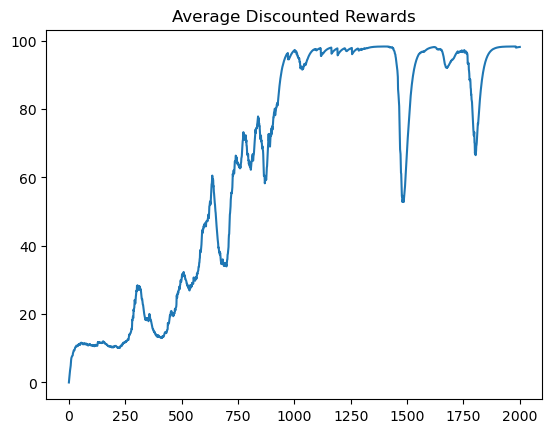

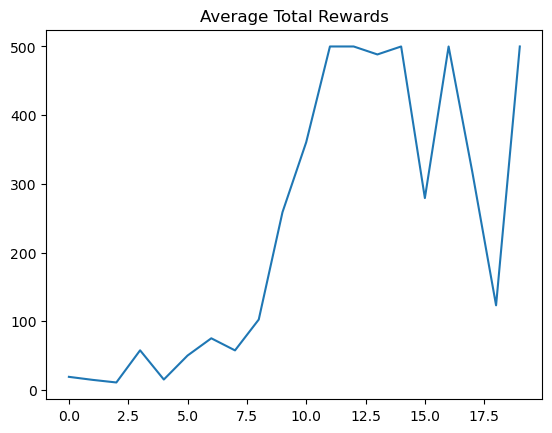

In [ ]:
# In the new version of Gymnasium you need different environments for rendering and no rendering.
# Here we instaintiate two versions of cartpole, one that animates the episodes (which slows everything
# down), and another that does not animate.
env = gym.make('CartPole-v1')
env_render = gym.make('CartPole-v1', render_mode='human')

# Make a policy network.
policy = PolicyNetWithBaseline(env, inner_size=32)

# Train the agent.
(total, average) = reinforce(policy, env, env_render, num_episodes=2000, baseline=True, comment='-VALUE')

plt.plot(total)
plt.title('Average Discounted Rewards')
plt.figure()
plt.plot(average)
plt.title('Average Total Rewards')

# Run the final agent for shits and giggles.
env_render = gym.make('CartPole-v1', render_mode='human')
for _ in range(1):
    run_episode(env_render, policy)
env_render.close()

# Close up everything
env_render.close()
env.close()

**Last Things Last**: My implementation does a **super crappy** job of evaluating the agent performance during training. The running average is not a very good metric. Modify my implementation so that every $N$ iterations (make $N$ an argument to the training function) the agent is run for $M$ episodes in the environment. Collect and return: (1) The average **total** reward received over the $M$ iterations; and (2) the average episode length. Analyze the performance of your agents with these new metrics.

NEWW !!!

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.tensorboard import SummaryWriter



In [ ]:
def select_action(obs, policy):
    probs, value = policy(obs)
    dist = Categorical(probs)
    action = dist.sample()
    log_prob = dist.log_prob(action)
    return action.item(), log_prob.reshape(1), value

def compute_returns(rewards, gamma):
    return np.flip(np.cumsum([gamma**(i+1)*r for (i, r) in enumerate(rewards)][::-1]), 0).copy()

def run_episode(env, policy, maxlen=500):
    observations = []
    actions = []
    log_probs = []
    rewards = []
    values = []
    obs, info = env.reset()
    for i in range(maxlen):
        obs = torch.tensor(obs, dtype=torch.float32)
        action, log_prob, value = select_action(obs, policy)
        observations.append(obs)
        actions.append(action)
        log_probs.append(log_prob)
        values.append(value)
        obs, reward, term, trunc, _ = env.step(action)
        rewards.append(reward)
        if term or trunc:
            break
    return observations, actions, torch.cat(log_probs), rewards, values

def evaluate_policy(env, policy, num_episodes):
    total_rewards = []
    episode_lengths = []
    for _ in range(num_episodes):
        _, _, _, rewards, _ = run_episode(env, policy)
        total_rewards.append(np.sum(rewards))
        episode_lengths.append(len(rewards))
    avg_total_reward = np.mean(total_rewards)
    avg_episode_length = np.mean(episode_lengths)
    return avg_total_reward, avg_episode_length

def reinforce(policy, env, env_render=None, gamma=0.99, num_episodes=10, eval_interval=100, eval_episodes=10, display=False, baseline=True, comment=''):
    opt = torch.optim.Adam(policy.parameters(), lr=1e-2)
    writer = SummaryWriter(comment=comment)
    running_rewards = [0.0]
    average_rewards = []
    avg_episode_lengths = []

    policy.train()
    for episode in range(num_episodes):
        observations, actions, log_probs, rewards, values = run_episode(env, policy)
        returns = torch.tensor(compute_returns(rewards, gamma), dtype=torch.float32)
        values = torch.tensor(values, dtype=torch.float32)

        running_rewards.append(0.05 * returns[0].item() + 0.95 * running_rewards[-1])
        writer.add_scalar('Running', running_rewards[-1], episode)

        if baseline:
            targets = returns - values
        else:
            targets = returns

        opt.zero_grad()
        loss = (-log_probs * targets).mean()
        if baseline:
            loss_value = F.mse_loss(values, returns)
            loss += loss_value
        loss.backward()
        opt.step()

        if episode % eval_interval == 0:
            policy.eval()
            avg_reward, avg_length = evaluate_policy(env, policy, eval_episodes)
            average_rewards.append(avg_reward)
            avg_episode_lengths.append(avg_length)
            writer.add_scalar('Average Reward', avg_reward, episode)
            writer.add_scalar('Average Episode Length', avg_length, episode)
            print(f'Episode {episode}: Avg Reward = {avg_reward}, Avg Episode Length = {avg_length}')
            if display:
                run_episode(env_render, policy)
            policy.train()

    policy.eval()
    return running_rewards, average_rewards, avg_episode_lengths

class PolicyNetWithBaseline(nn.Module):
    def __init__(self, env, inner_size):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], inner_size)
        self.fc2_policy = nn.Linear(inner_size, env.action_space.n)
        self.fc2_value = nn.Linear(inner_size, 1)
        self.relu = nn.ReLU()

    def forward(self, s):
        s = F.relu(self.fc1(s))
        s_policy = F.softmax(self.fc2_policy(s), dim=-1)
        s_value = self.fc2_value(s)
        return s_policy, s_value



In [ ]:
env = gym.make('CartPole-v1')
env_render = gym.make('CartPole-v1', render_mode='human')
policy = PolicyNetWithBaseline(env, inner_size=32)
total_rewards, average_rewards, avg_episode_lengths = reinforce(policy, env, env_render, num_episodes=2000, eval_interval=100, eval_episodes=10, baseline=True, comment='-VALUE')



Episode 0: Avg Reward = 26.6, Avg Episode Length = 26.6
Episode 100: Avg Reward = 68.4, Avg Episode Length = 68.4
Episode 200: Avg Reward = 112.4, Avg Episode Length = 112.4
Episode 300: Avg Reward = 71.4, Avg Episode Length = 71.4
Episode 400: Avg Reward = 9.9, Avg Episode Length = 9.9
Episode 500: Avg Reward = 9.7, Avg Episode Length = 9.7
Episode 600: Avg Reward = 13.1, Avg Episode Length = 13.1
Episode 700: Avg Reward = 403.0, Avg Episode Length = 403.0
Episode 800: Avg Reward = 169.1, Avg Episode Length = 169.1
Episode 900: Avg Reward = 39.5, Avg Episode Length = 39.5
Episode 1000: Avg Reward = 68.9, Avg Episode Length = 68.9
Episode 1100: Avg Reward = 41.9, Avg Episode Length = 41.9
Episode 1200: Avg Reward = 43.0, Avg Episode Length = 43.0
Episode 1300: Avg Reward = 500.0, Avg Episode Length = 500.0
Episode 1400: Avg Reward = 500.0, Avg Episode Length = 500.0
Episode 1500: Avg Reward = 500.0, Avg Episode Length = 500.0
Episode 1600: Avg Reward = 185.0, Avg Episode Length = 185.0

Text(0.5, 1.0, 'Average Episode Lengths')

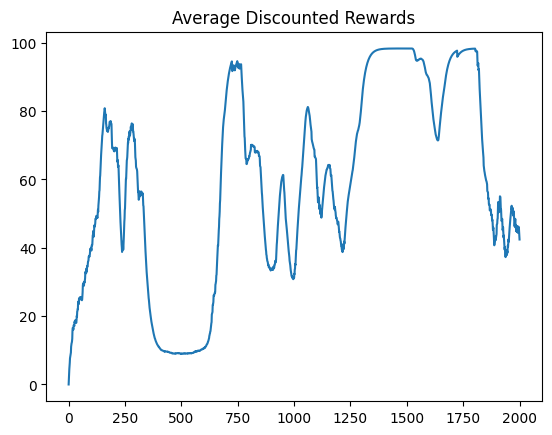

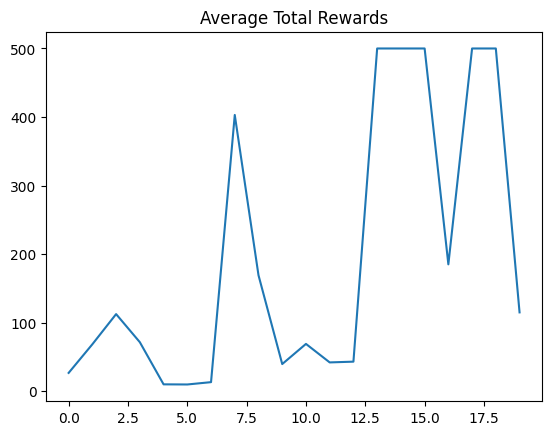

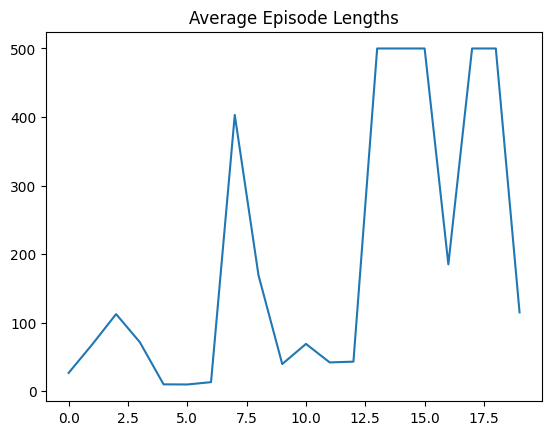

In [ ]:
plt.plot(total_rewards)
plt.title('Average Discounted Rewards')
plt.figure()
plt.plot(average_rewards)
plt.title('Average Total Rewards')
plt.figure()
plt.plot(avg_episode_lengths)
plt.title('Average Episode Lengths')



In [ ]:
env_render = gym.make('CartPole-v1', render_mode='human')
for _ in range(1):
    run_episode(env_render, policy)
env_render.close()
env.close()


In [ ]:
!pip install gymnasium

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.tensorboard import SummaryWriter



In [ ]:
# Instantiate environments
env_render = gym.make('CartPole-v1', render_mode='human')
env = gym.make('CartPole-v1')

# Define the policy network with baseline
class PolicyNetWithBaseline(nn.Module):
    def __init__(self, env, inner_size):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], inner_size)
        self.fc2_policy = nn.Linear(inner_size, env.action_space.n)
        self.fc2_value = nn.Linear(inner_size, 1)

    def forward(self, s):
        s = F.relu(self.fc1(s))
        s_policy = F.softmax(self.fc2_policy(s), dim=-1)
        s_value = self.fc2_value(s)
        return (s_policy, s_value)

# Function to select an action based on policy
def select_action(obs, policy):
    (probs, value) = policy(obs)
    dist = Categorical(probs)
    action = dist.sample()
    log_prob = dist.log_prob(action)
    return (action.item(), log_prob.reshape(1), value)

# Compute discounted returns
def compute_returns(rewards, gamma):
    return np.flip(np.cumsum([gamma**(i+1)*r for (i, r) in enumerate(rewards)][::-1]), 0).copy()

# Run an episode and collect data
def run_episode(env, policy, maxlen=500):
    observations, actions, log_probs, rewards, values = [], [], [], [], []
    obs, info = env.reset()
    for _ in range(maxlen):
        obs = torch.tensor(obs, dtype=torch.float32)
        action, log_prob, value = select_action(obs, policy)
        observations.append(obs)
        actions.append(action)
        log_probs.append(log_prob)
        values.append(value)
        obs, reward, term, trunc, _ = env.step(action)
        rewards.append(reward)
        if term or trunc:
            break
    return observations, actions, torch.cat(log_probs), rewards, values



In [ ]:
# Improved REINFORCE algorithm
def reinforce(policy, env, env_render=None, gamma=0.99, num_episodes=10, eval_every=100, eval_episodes=10, baseline=True, display=False, comment=''):
    opt = torch.optim.Adam(policy.parameters(), lr=1e-2)
    writer = SummaryWriter(comment=comment)
    running_rewards = [0.0]
    average_rewards = []
    average_lengths = []

    policy.train()
    for episode in range(num_episodes):
        observations, actions, log_probs, rewards, values = run_episode(env, policy)
        returns = torch.tensor(compute_returns(rewards, gamma), dtype=torch.float32)
        values = torch.tensor(values, dtype=torch.float32)
        running_rewards.append(0.05 * returns[0].item() + 0.95 * running_rewards[-1])
        writer.add_scalar('Running', running_rewards[-1], episode)

        targets = returns - values if baseline else returns
        opt.zero_grad()
        loss = (-log_probs * targets).mean()
        if baseline:
            loss += F.mse_loss(values, returns)
        loss.backward()
        opt.step()

        if episode % eval_every == 0:
            policy.eval()
            total_reward = 0
            total_length = 0
            for _ in range(eval_episodes):
                _, _, _, rewards, _ = run_episode(env, policy)
                total_reward += np.sum(rewards)
                total_length += len(rewards)
            average_rewards.append(total_reward / eval_episodes)
            average_lengths.append(total_length / eval_episodes)
            writer.add_scalar('Average Reward', average_rewards[-1], episode)
            writer.add_scalar('Average Length', average_lengths[-1], episode)
            print(f'Episode {episode}, Average Reward: {average_rewards[-1]}, Average Length: {average_lengths[-1]}')
            if display:
                run_episode(env_render, policy)
            policy.train()
            print(f'Running reward: {running_rewards[-1]}')

    policy.eval()
    return running_rewards, average_rewards, average_lengths



Episode 0, Average Reward: 20.0, Average Length: 20.0
Running reward: 0.819156837463379
Episode 100, Average Reward: 13.3, Average Length: 13.3
Running reward: 14.230823254199894
Episode 200, Average Reward: 47.5, Average Length: 47.5
Running reward: 37.47268324403348
Episode 300, Average Reward: 240.3, Average Length: 240.3
Running reward: 56.654925201112626
Episode 400, Average Reward: 477.4, Average Length: 477.4
Running reward: 92.80856133878684
Episode 500, Average Reward: 183.0, Average Length: 183.0
Running reward: 92.73416905587777
Episode 600, Average Reward: 500.0, Average Length: 500.0
Running reward: 98.2758219662554
Episode 700, Average Reward: 500.0, Average Length: 500.0
Running reward: 98.25203453050439
Episode 800, Average Reward: 403.0, Average Length: 403.0
Running reward: 97.36290660929686
Episode 900, Average Reward: 400.4, Average Length: 400.4
Running reward: 97.64591013824574
Episode 1000, Average Reward: 159.2, Average Length: 159.2
Running reward: 77.420920026

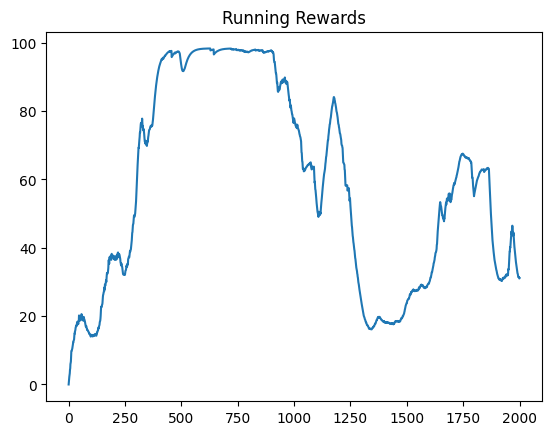

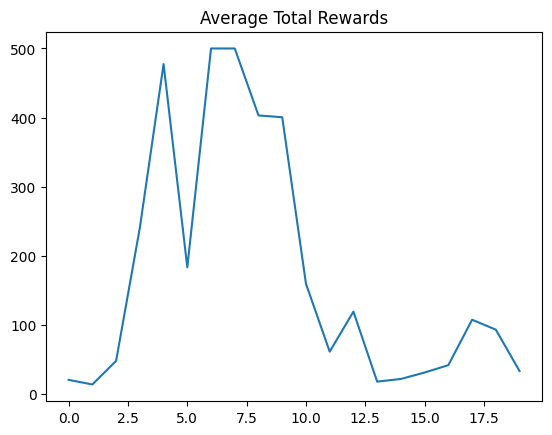

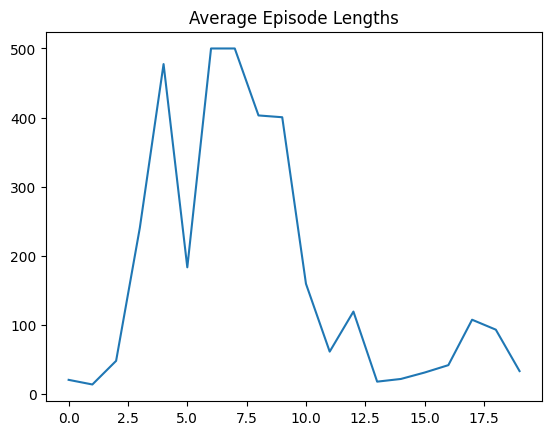

In [ ]:
# Training and evaluating the policy
policy = PolicyNetWithBaseline(env, inner_size=32)
running_rewards, average_rewards, average_lengths = reinforce(policy, env, env_render, num_episodes=2000, eval_every=100, baseline=True, comment='-VALUE')

plt.plot(running_rewards)
plt.title('Running Rewards')
plt.show()

plt.plot(average_rewards)
plt.title('Average Total Rewards')
plt.show()

plt.plot(average_lengths)
plt.title('Average Episode Lengths')
plt.show()

# Final run to visualize the agent
env_render = gym.make('CartPole-v1', render_mode='human')
run_episode(env_render, policy)
env_render.close()
env.close()


-----
## Exercise 2: `REINFORCE` with a Value Baseline (warm up)

In this exercise we will augment my implementation (or your own) of `REINFORCE` to subtract a baseline from the target in the update equation in order to stabilize (and hopefully speed-up) convergence. For now we will stick to the Cartpole environment.



**First Things First**: Recall from the slides on Deep Reinforcement Learning that we can **subtract** any function that doesn't depend on the current action from the q-value without changing the (maximum of our) objecttive function $J$:  

$$ \nabla J(\boldsymbol{\theta}) \propto \sum_{s} \mu(s) \sum_a \left( q_{\pi}(s, a) - b(s) \right) \nabla \pi(a \mid s, \boldsymbol{\theta}) $$

In `REINFORCE` this means we can subtract from our target $G_t$:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - b(S_t)) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

Since we are only interested in the **maximum** of our objective, we can also **rescale** our target by any function that also doesn't depend on the action. A **simple baseline** which is even independent of the state -- that is, it is **constant** for each episode -- is to just **standardize rewards within the episode**. So, we **subtract** the average return and **divide** by the variance of returns:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha \left(\frac{G_t - \bar{G}}{\sigma_G}\right) \nabla  \pi(A_t \mid s, \boldsymbol{\theta}) $$

This baseline is **already** implemented in my implementation of `REINFORCE`. Experiment with and without this standardization baseline and compare the performance. We are going to do something more interesting.

In [ ]:
# Your code here. Modify your implementation of `REINFORCE` to optionally use the standardize baseline.

In [ ]:
# Instantiate environments
env_render = gym.make('CartPole-v1', render_mode='human')
env = gym.make('CartPole-v1')

# Define the policy network with baseline
class PolicyNetWithBaseline(nn.Module):
    def __init__(self, env, inner_size):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], inner_size)
        self.fc2_policy = nn.Linear(inner_size, env.action_space.n)
        self.fc2_value = nn.Linear(inner_size, 1)

    def forward(self, s):
        s = F.relu(self.fc1(s))
        s_policy = F.softmax(self.fc2_policy(s), dim=-1)
        s_value = self.fc2_value(s)
        return (s_policy, s_value)

# Function to select an action based on policy
def select_action(obs, policy):
    (probs, value) = policy(obs)
    dist = Categorical(probs)
    action = dist.sample()
    log_prob = dist.log_prob(action)
    return (action.item(), log_prob.reshape(1), value)

# Compute discounted returns
def compute_returns(rewards, gamma):
    return np.flip(np.cumsum([gamma**(i+1)*r for (i, r) in enumerate(rewards)][::-1]), 0).copy()

# Run an episode and collect data
def run_episode(env, policy, maxlen=500):
    observations, actions, log_probs, rewards, values = [], [], [], [], []
    obs, info = env.reset()
    for _ in range(maxlen):
        obs = torch.tensor(obs, dtype=torch.float32)
        action, log_prob, value = select_action(obs, policy)
        observations.append(obs)
        actions.append(action)
        log_probs.append(log_prob)
        values.append(value)
        obs, reward, term, trunc, _ = env.step(action)
        rewards.append(reward)
        if term or trunc:
            break
    return observations, actions, torch.cat(log_probs), rewards, values

# Improved REINFORCE algorithm with baseline
def reinforce(policy, env, env_render=None, gamma=0.99, num_episodes=10, eval_every=100, eval_episodes=10, baseline=True, standardize_rewards=False, display=False, comment=''):
    opt = torch.optim.Adam(policy.parameters(), lr=1e-2)
    writer = SummaryWriter(comment=comment)
    running_rewards = [0.0]
    average_rewards = []
    average_lengths = []

    policy.train()
    for episode in range(num_episodes):
        observations, actions, log_probs, rewards, values = run_episode(env, policy)
        returns = torch.tensor(compute_returns(rewards, gamma), dtype=torch.float32)
        values = torch.tensor(values, dtype=torch.float32)
        running_rewards.append(0.05 * returns[0].item() + 0.95 * running_rewards[-1])
        writer.add_scalar('Running', running_rewards[-1], episode)

        if baseline:
            targets = returns - values
        else:
            targets = returns

        if standardize_rewards:
            targets = (targets - targets.mean()) / (targets.std() + 1e-8)

        opt.zero_grad()
        loss = (-log_probs * targets).mean()
        if baseline:
            loss += F.mse_loss(values, returns)
        loss.backward()
        opt.step()

        if episode % eval_every == 0:
            policy.eval()
            total_reward = 0
            total_length = 0
            for _ in range(eval_episodes):
                _, _, _, rewards, _ = run_episode(env, policy)
                total_reward += np.sum(rewards)
                total_length += len(rewards)
            average_rewards.append(total_reward / eval_episodes)
            average_lengths.append(total_length / eval_episodes)
            writer.add_scalar('Average Reward', average_rewards[-1], episode)
            writer.add_scalar('Average Length', average_lengths[-1], episode)
            print(f'Episode {episode}, Average Reward: {average_rewards[-1]}, Average Length: {average_lengths[-1]}')
            if display:
                run_episode(env_render, policy)
            policy.train()
            print(f'Running reward: {running_rewards[-1]}')

    policy.eval()
    return running_rewards, average_rewards, average_lengths



Episode 0, Average Reward: 18.0, Average Length: 18.0
Running reward: 0.9819285392761231
Episode 100, Average Reward: 196.8, Average Length: 196.8
Running reward: 62.881586245614585
Episode 200, Average Reward: 439.3, Average Length: 439.3
Running reward: 90.6248818437795
Episode 300, Average Reward: 458.1, Average Length: 458.1
Running reward: 97.10595131276031
Episode 400, Average Reward: 373.5, Average Length: 373.5
Running reward: 94.62772904906875
Episode 500, Average Reward: 500.0, Average Length: 500.0
Running reward: 97.3333412472295
Episode 600, Average Reward: 485.0, Average Length: 485.0
Running reward: 98.32622057398832
Episode 700, Average Reward: 56.6, Average Length: 56.6
Running reward: 81.68848285095495
Episode 800, Average Reward: 500.0, Average Length: 500.0
Running reward: 95.19993943679775
Episode 900, Average Reward: 500.0, Average Length: 500.0
Running reward: 98.330878235627
Episode 1000, Average Reward: 500.0, Average Length: 500.0
Running reward: 98.3487227926

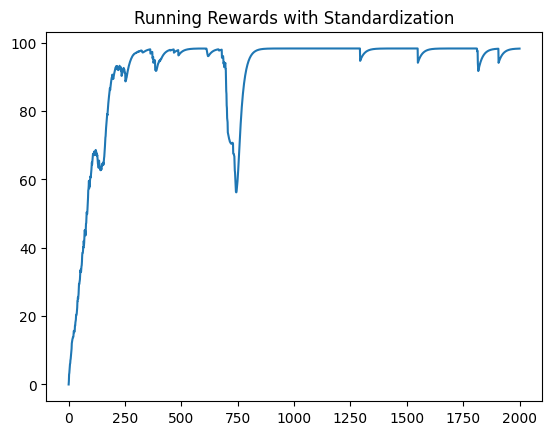

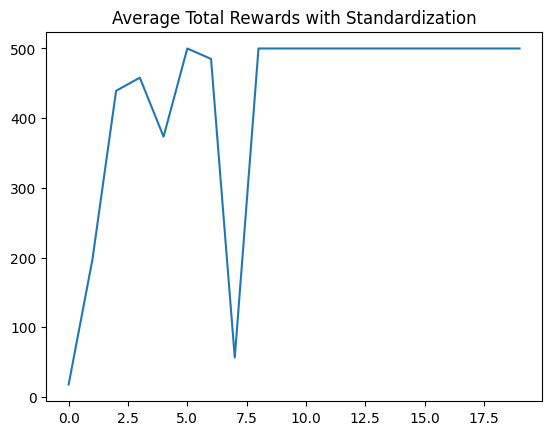

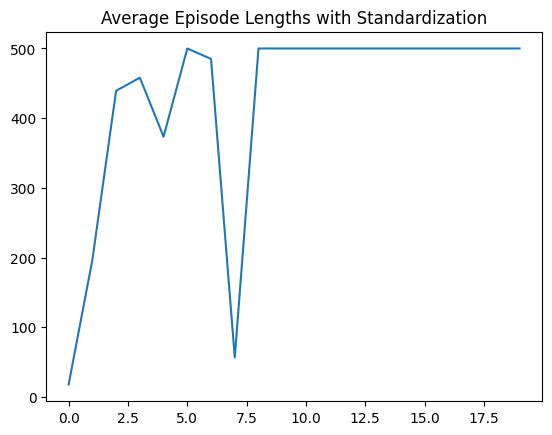

Episode 0, Average Reward: 19.0, Average Length: 19.0
Running reward: 0.5180756568908692
Episode 100, Average Reward: 48.9, Average Length: 48.9
Running reward: 33.122012081637045
Episode 200, Average Reward: 129.7, Average Length: 129.7
Running reward: 58.71245799687001
Episode 300, Average Reward: 124.8, Average Length: 124.8
Running reward: 74.9202323784113
Episode 400, Average Reward: 25.6, Average Length: 25.6
Running reward: 17.602504337905064
Episode 500, Average Reward: 466.7, Average Length: 466.7
Running reward: 88.20476827100961
Episode 600, Average Reward: 256.9, Average Length: 256.9
Running reward: 84.46028440393476
Episode 700, Average Reward: 500.0, Average Length: 500.0
Running reward: 88.26110947718
Episode 800, Average Reward: 120.0, Average Length: 120.0
Running reward: 90.24324257930968
Episode 900, Average Reward: 403.4, Average Length: 403.4
Running reward: 84.82133163815097
Episode 1000, Average Reward: 73.8, Average Length: 73.8
Running reward: 65.8978390209596

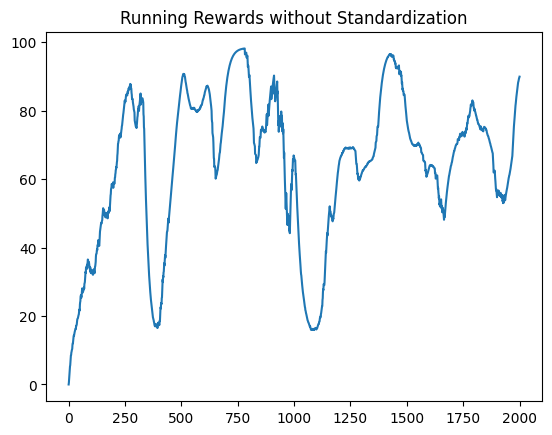

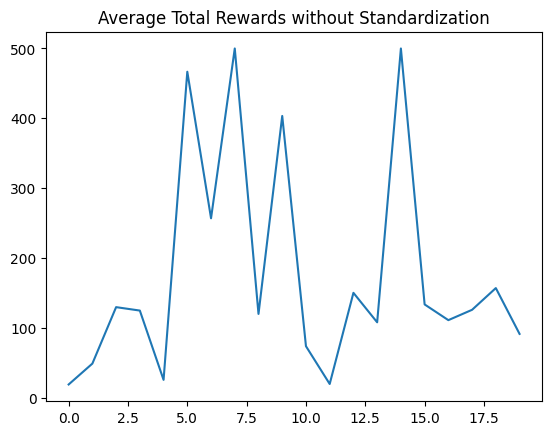

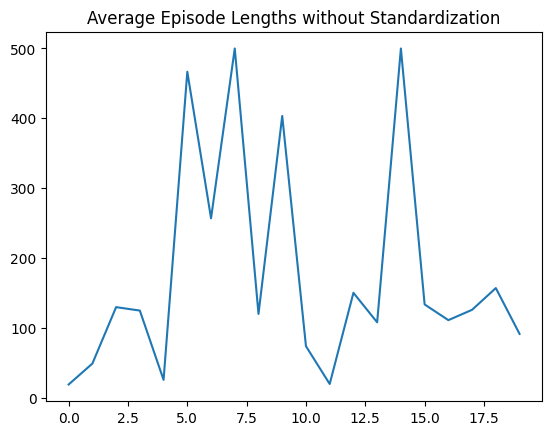

In [ ]:
# Training and evaluating the policy with and without standardization
policy = PolicyNetWithBaseline(env, inner_size=32)
running_rewards, average_rewards, average_lengths = reinforce(policy, env, env_render, num_episodes=2000, eval_every=100, baseline=True, standardize_rewards=True, comment='-STANDARDIZED')

plt.plot(running_rewards)
plt.title('Running Rewards with Standardization')
plt.show()

plt.plot(average_rewards)
plt.title('Average Total Rewards with Standardization')
plt.show()

plt.plot(average_lengths)
plt.title('Average Episode Lengths with Standardization')
plt.show()

policy = PolicyNetWithBaseline(env, inner_size=32)
running_rewards, average_rewards, average_lengths = reinforce(policy, env, env_render, num_episodes=2000, eval_every=100, baseline=True, standardize_rewards=False, comment='-NO_STANDARDIZATION')

plt.plot(running_rewards)
plt.title('Running Rewards without Standardization')
plt.show()

plt.plot(average_rewards)
plt.title('Average Total Rewards without Standardization')
plt.show()

plt.plot(average_lengths)
plt.title('Average Episode Lengths without Standardization')
plt.show()

# Final run to visualize the agent
env_render = gym.make('CartPole-v1', render_mode='human')
run_episode(env_render, policy)
env_render.close()
env.close()

**The Real Exercise**: Standard practice is to use the state-value function $v(s)$ as a baseline. This is intuitively appealing -- we are more interested in updating out policy for returns that estimate the current **value** worse. Our new update becomes:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - \tilde{v}(S_t \mid \mathbf{w})) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

where $\tilde{v}(s \mid \mathbf{w})$ is a **deep neural network** with parameters $w$ that estimates $v_\pi(s)$. What neural network? Typically, we use the **same** network architecture as that of the Policy.

**Your Task**: Modify your implementation to fit a second, baseline network to estimate the value function and use it as **baseline**.

In [ ]:
# Your code here.

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt


In [ ]:

# Instantiate environments
env_render = gym.make('CartPole-v1', render_mode='human')
env = gym.make('CartPole-v1')

# Define the policy network
class PolicyNet(nn.Module):
    def __init__(self, env, inner_size):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], inner_size)
        self.fc2 = nn.Linear(inner_size, env.action_space.n)

    def forward(self, s):
        s = F.relu(self.fc1(s))
        s_policy = F.softmax(self.fc2(s), dim=-1)
        return s_policy

# Define the value network
class ValueNet(nn.Module):
    def __init__(self, env, inner_size):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], inner_size)
        self.fc2 = nn.Linear(inner_size, 1)

    def forward(self, s):
        s = F.relu(self.fc1(s))
        s_value = self.fc2(s)
        return s_value

# Function to select an action based on policy
def select_action(obs, policy):
    probs = policy(obs)
    dist = Categorical(probs)
    action = dist.sample()
    log_prob = dist.log_prob(action)
    return action.item(), log_prob

# Compute discounted returns
def compute_returns(rewards, gamma):
    returns = np.zeros_like(rewards)
    G = 0
    for t in reversed(range(len(rewards))):
        G = rewards[t] + gamma * G
        returns[t] = G
    return returns

# Run an episode and collect data
def run_episode(env, policy, value_net, maxlen=500):
    observations, actions, log_probs, rewards, values = [], [], [], [], []
    obs = env.reset()
    if isinstance(obs, tuple):  # Handle compatibility with different Gym versions
        obs = obs[0]

    for _ in range(maxlen):
        obs_tensor = torch.tensor(obs, dtype=torch.float32)
        action, log_prob = select_action(obs_tensor, policy)
        value = value_net(obs_tensor)

        observations.append(obs_tensor.unsqueeze(0))  # Add batch dimension
        actions.append(action)
        log_probs.append(log_prob.unsqueeze(0))  # Ensure log_prob is 1D
        values.append(value.unsqueeze(0))  # Ensure value is 1D

        step_result = env.step(action)
        obs, reward = step_result[0], step_result[1]
        term = step_result[2] if len(step_result) > 2 else False
        trunc = step_result[3] if len(step_result) > 3 else False

        rewards.append(reward)
        if term or trunc:
            break

    return (torch.cat(observations), actions, torch.cat(log_probs), rewards, torch.cat(values))

# Improved REINFORCE algorithm with value network as baseline
def reinforce(policy, value_net, env, env_render=None, gamma=0.99, num_episodes=2000, eval_every=100, eval_episodes=10, baseline=True, display=False, comment=''):
    policy_opt = torch.optim.Adam(policy.parameters(), lr=1e-2)
    value_opt = torch.optim.Adam(value_net.parameters(), lr=1e-2)
    writer = SummaryWriter(comment=comment)
    running_rewards = [0.0]
    average_rewards = []
    average_lengths = []

    policy.train()
    value_net.train()
    for episode in range(num_episodes):
        observations, actions, log_probs, rewards, values = run_episode(env, policy, value_net)
        returns = torch.tensor(compute_returns(rewards, gamma), dtype=torch.float32)
        running_rewards.append(0.05 * returns[0].item() + 0.95 * running_rewards[-1])
        writer.add_scalar('Running', running_rewards[-1], episode)

        if baseline:
            advantages = returns - values.squeeze()
        else:
            advantages = returns

        policy_opt.zero_grad()
        policy_loss = (-log_probs * advantages.detach()).mean()  # Detach advantages
        policy_loss.backward()
        policy_opt.step()

        value_opt.zero_grad()
        value_loss = F.mse_loss(values.squeeze(), returns)
        value_loss.backward()
        value_opt.step()

        if episode % eval_every == 0:
            policy.eval()
            total_reward = 0
            total_length = 0
            for _ in range(eval_episodes):
                _, _, _, rewards, _ = run_episode(env, policy, value_net)
                total_reward += np.sum(rewards)
                total_length += len(rewards)
            average_rewards.append(total_reward / eval_episodes)
            average_lengths.append(total_length / eval_episodes)
            writer.add_scalar('Average Reward', average_rewards[-1], episode)
            writer.add_scalar('Average Length', average_lengths[-1], episode)
            print(f'Episode {episode}, Average Reward: {average_rewards[-1]}, Average Length: {average_lengths[-1]}')
            if display:
                run_episode(env_render, policy, value_net)
            policy.train()
            print(f'Running reward: {running_rewards[-1]}')

    policy.eval()
    value_net.eval()
    return running_rewards, average_rewards, average_lengths



/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0, Average Reward: 16.8, Average Length: 16.8
Running reward: 0.5233087062835694
Episode 100, Average Reward: 142.1, Average Length: 142.1
Running reward: 70.79005797478136
Episode 200, Average Reward: 473.2, Average Length: 473.2
Running reward: 97.97431689959535
Episode 300, Average Reward: 500.0, Average Length: 500.0
Running reward: 99.2046024642231
Episode 400, Average Reward: 500.0, Average Length: 500.0
Running reward: 99.22050434157839
Episode 500, Average Reward: 287.0, Average Length: 287.0
Running reward: 98.80092729361498
Episode 600, Average Reward: 500.0, Average Length: 500.0
Running reward: 99.32542182337909
Episode 700, Average Reward: 500.0, Average Length: 500.0
Running reward: 99.34284514392438
Episode 800, Average Reward: 500.0, Average Length: 500.0
Running reward: 99.34294829920276
Episode 900, Average Reward: 500.0, Average Length: 500.0
Running reward: 99.34294890993661
Episode 1000, Average Reward: 500.0, Average Length: 500.0
Running reward: 97.000844

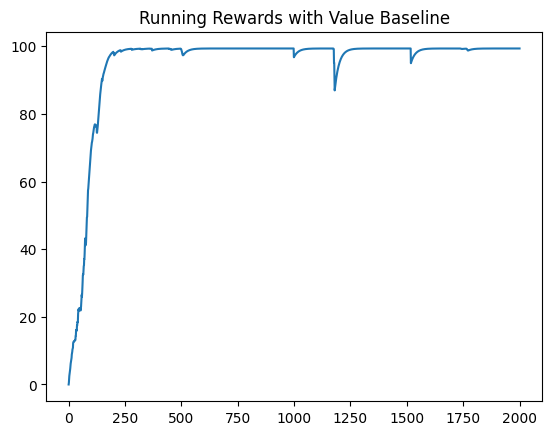

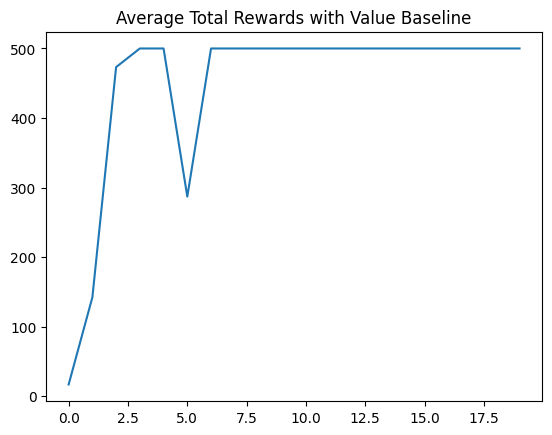

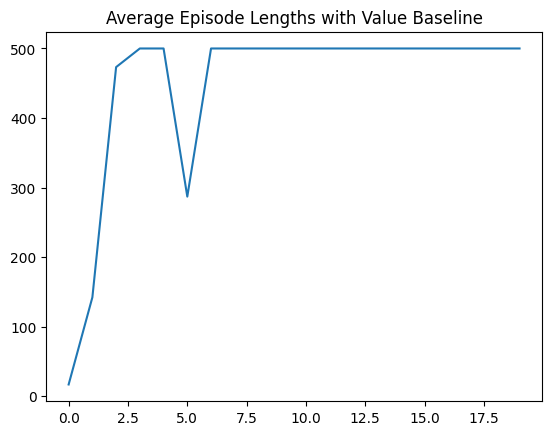

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
# Training and evaluating the policy with value network baseline
policy = PolicyNet(env, inner_size=32)
value_net = ValueNet(env, inner_size=32)
running_rewards, average_rewards, average_lengths = reinforce(policy, value_net, env, env_render, num_episodes=2000, eval_every=100, baseline=True, comment='-VALUE_BASELINE')

plt.plot(running_rewards)
plt.title('Running Rewards with Value Baseline')
plt.show()

plt.plot(average_rewards)
plt.title('Average Total Rewards with Value Baseline')
plt.show()

plt.plot(average_lengths)
plt.title('Average Episode Lengths with Value Baseline')
plt.show()

# Final run to visualize the agent
env_render = gym.make('CartPole-v1', render_mode='human')
run_episode(env_render, policy, value_net)
env_render.close()
env.close()


-----
## Exercise 3: Going Deeper

As usual, pick **AT LEAST ONE** of the following exercises to complete.

### Exercise 3.1: Solving Lunar Lander with `REINFORCE` (easy)

Use my (or even better, improve on my) implementation of `REINFORCE` to solve the [Lunar Lander Environment](https://gymnasium.farama.org/environments/box2d/lunar_lander/). This environment is a little bit harder than Cartpole, but not much. Make sure you perform the same types of analyses we did during the lab session to quantify and qualify the performance of your agents.



In [ ]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 6.7 MB/s eta 0:00:00


In [ ]:
!apt-get install swig


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 45 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (1,335 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 123586 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubu

In [ ]:
!pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.7 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2349144 sha256=fb945dc0e9808716b71474a274dbbf10d5fd724c119de1e8c1ad140597c047aa
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


To resolve the environment we set that the average reward need to be >= 200 for the last 10 episodes !

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from collections import deque

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
# Instantiate environments
env_render = gym.make('LunarLander-v2', render_mode='human')
env = gym.make('LunarLander-v2')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
class ActorNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(ActorNet, self).__init__()
        self.dense_layer_1 = nn.Linear(state_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        x = torch.clamp(x,-1.1,1.1)
        x = F.relu(self.dense_layer_1(x))
        x = F.relu(self.dense_layer_2(x))
        return F.softmax(self.output(x),dim=-1) #-1 to take softmax of last dimension

class ValueFunctionNet(nn.Module):
    def __init__(self, state_size, hidden_size):
        super(ValueFunctionNet, self).__init__()
        self.dense_layer_1 = nn.Linear(state_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = torch.clamp(x,-1.1,1.1)
        x = F.relu(self.dense_layer_1(x))
        x = F.relu(self.dense_layer_2(x))
        return self.output(x)

#REINFORCE
class PGAgent():
    def __init__(self, state_size, action_size, hidden_size, actor_lr, vf_lr, discount ):
        self.action_size = action_size
        self.actor_net = ActorNet(state_size, action_size, hidden_size).to(device)
        self.vf_net = ValueFunctionNet(state_size, hidden_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_net.parameters(), lr=actor_lr)
        self.vf_optimizer = optim.Adam(self.vf_net.parameters(), lr=vf_lr)
        self.discount = discount

    def select_action(self, state):
        #get action probs then randomly sample from the probabilities
        with torch.no_grad():
            input_state = torch.FloatTensor(state).to(device)
            action_probs = self.actor_net(input_state)
            #detach and turn to numpy to use with np.random.choice()
            action_probs = action_probs.detach().cpu().numpy()
            action = np.random.choice(np.arange(self.action_size), p=action_probs)
        return action

    def train(self, state_list, action_list, reward_list):

        #turn rewards into return
        trajectory_len = len(reward_list)
        return_array = np.zeros((trajectory_len,))
        g_return = 0.
        for i in range(trajectory_len-1,-1,-1):
            g_return = reward_list[i] + self.discount*g_return
            return_array[i] = g_return

        # create tensors
        state_t = torch.FloatTensor(state_list).to(device)
        action_t = torch.LongTensor(action_list).to(device).view(-1,1)
        return_t = torch.FloatTensor(return_array).to(device).view(-1,1)

        # get value function estimates
        vf_t = self.vf_net(state_t).to(device)
        with torch.no_grad():
            advantage_t = return_t - vf_t

        # calculate actor loss
        selected_action_prob = self.actor_net(state_t).gather(1, action_t)
        # REINFORCE loss:
        #actor_loss = torch.mean(-torch.log(selected_action_prob) * return_t)
        # REINFORCE Baseline loss:
        actor_loss = torch.mean(-torch.log(selected_action_prob) * advantage_t)
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # calculate vf loss
        loss_fn = nn.MSELoss()
        vf_loss = loss_fn(vf_t, return_t)
        self.vf_optimizer.zero_grad()
        vf_loss.backward()
        self.vf_optimizer.step()

        return actor_loss.detach().cpu().numpy(), vf_loss.detach().cpu().numpy()

In [ ]:
# initialize environment
env = gym.make('LunarLander-v2')
action_size = env.action_space.n
state_size = env.observation_space.shape[0]

# set seed
seed = 31
env.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# hyperparameters
episodes = 5000 # run agent for this many episodes
hidden_size = 256 # number of units in NN hidden layers
actor_lr = 0.002 # learning rate for actor
value_function_lr = 0.002 # learning rate for value function
discount = 0.99 # discount factor gamma value
reward_scale = 0.01 #scale reward by this amount

# create agent
agent = PGAgent(state_size, action_size, hidden_size, actor_lr, value_function_lr, discount)

/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [ ]:
stats_rewards_list = [] # store stats for plotting in this
stats_every = 10 # print stats every this many episodes
total_reward = 0
timesteps = 0
episode_length = 0
stats_actor_loss, stats_vf_loss = 0., 0.

for ep in range(episodes):
    state = env.reset()
    state_list, action_list, reward_list = [], [], []

    # stopping condition for training if agent reaches the amount of reward
    if len(stats_rewards_list) > stats_every and np.mean(stats_rewards_list[-stats_every:],axis=0)[1] > 200:
        print("Stopping at episode {} with average rewards of {} in last {} episodes".
            format(ep, np.mean(stats_rewards_list[-stats_every:],axis=0)[1], stats_every))
        break

    # train in each episode until episode is done
    while True:
        timesteps += 1
        #env.render()
        # select an action from the agent's policy
        action = agent.select_action(state)

        # enter action into the env
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        episode_length += 1
        # store agent's trajectory
        state_list.append(state)
        action_list.append(action)
        reward_list.append(reward*reward_scale)

        # end episode early
        if total_reward < -250:
            done = 1

        if done:
            actor_loss, vf_loss = agent.train(state_list, action_list, reward_list)
            stats_rewards_list.append((ep, total_reward, episode_length))
            stats_actor_loss += actor_loss
            stats_vf_loss += vf_loss
            total_reward = 0
            episode_length = 0
            if ep % stats_every == 0:
                print('Episode: {}'.format(ep),
                    'Timestep: {}'.format(timesteps),
                    'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
                    'Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
                    'Actor Loss: {:.4f}'.format(stats_actor_loss/stats_every),
                    'VF Loss: {:.4f}'.format(stats_vf_loss/stats_every))
                stats_actor_loss, stats_vf_loss = 0., 0.
            break

        state = next_state

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
<ipython-input-6-1c6e55693967>:56: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  state_t = torch.FloatTensor(state_list).to(device)


Episode: 0 Timestep: 63 Total reward: -112.4 Episode length: 63.0 Actor Loss: -0.0900 VF Loss: 0.0445
Episode: 10 Timestep: 1152 Total reward: -256.0 Episode length: 108.9 Actor Loss: -0.0436 VF Loss: 0.3049
Episode: 20 Timestep: 1834 Total reward: -239.2 Episode length: 68.2 Actor Loss: -0.1324 VF Loss: 0.1701
Episode: 30 Timestep: 2464 Total reward: -275.0 Episode length: 63.0 Actor Loss: 0.0707 VF Loss: 0.2839
Episode: 40 Timestep: 3081 Total reward: -273.6 Episode length: 61.7 Actor Loss: -0.1857 VF Loss: 0.2049
Episode: 50 Timestep: 3756 Total reward: -263.0 Episode length: 67.5 Actor Loss: 0.0008 VF Loss: 0.1966
Episode: 60 Timestep: 4462 Total reward: -232.7 Episode length: 70.6 Actor Loss: 0.1565 VF Loss: 0.1908
Episode: 70 Timestep: 5196 Total reward: -163.6 Episode length: 73.4 Actor Loss: 0.1307 VF Loss: 0.2746
Episode: 80 Timestep: 6032 Total reward: -163.1 Episode length: 83.6 Actor Loss: -0.3088 VF Loss: 0.3167
Episode: 90 Timestep: 6837 Total reward: -186.7 Episode lengt

The training successfully converged, as indicated by the high average rewards in the last 10 episodes (**203**). The low actor and value function losses further confirm that the policy and value networks have learned effectively. The increasing episode length suggests that the agent is performing more complex and extended sequences of actions to maximize rewards.

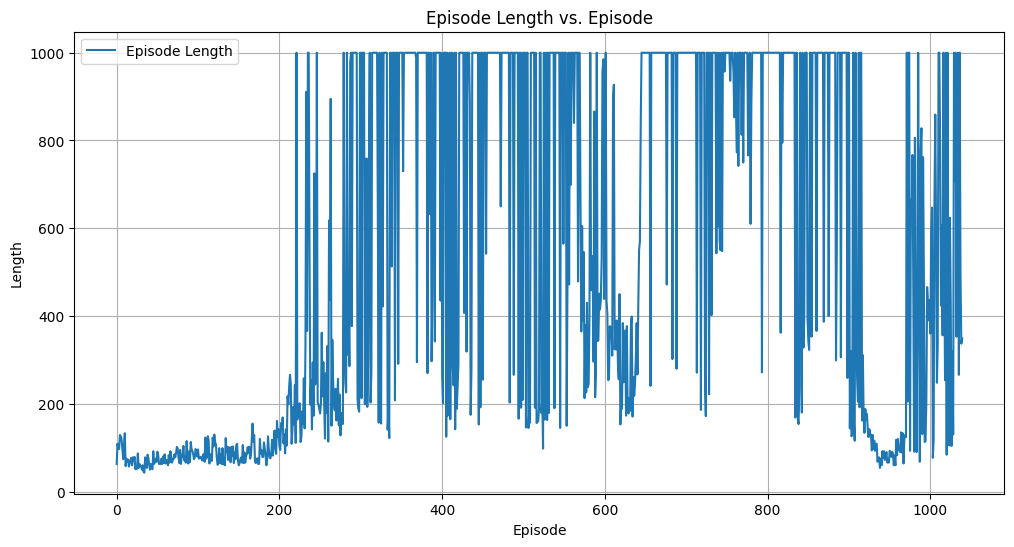

In [ ]:
# Extract data
episodes = [x[0] for x in stats_rewards_list]
rewards = [x[1] for x in stats_rewards_list]
lengths = [x[2] for x in stats_rewards_list]

# Plot episode lengths
plt.figure(figsize=(12, 6))
plt.plot(episodes, lengths, label='Episode Length')
plt.xlabel('Episode')
plt.ylabel('Length')
plt.title('Episode Length vs. Episode')
plt.legend()
plt.grid(True)
plt.show()



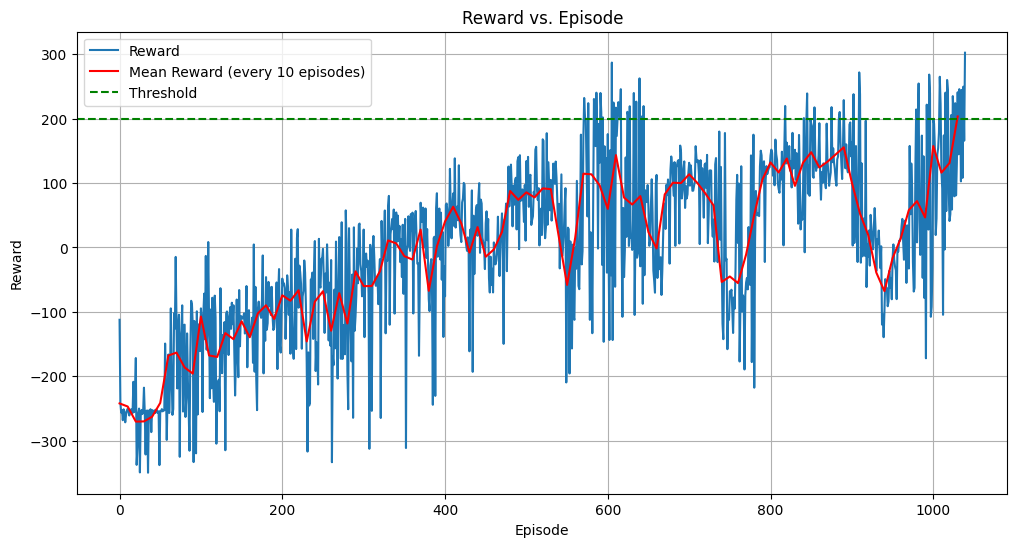

In [ ]:
# Calculate mean reward every 10 episodes
mean_rewards = []
for i in range(0, len(rewards), 10):
    mean_rewards.append(sum(rewards[i:i+10]) / len(rewards[i:i+10]))

mean_episodes = range(0, len(rewards), 10)


# Plot rewards with mean reward and threshold
threshold = 200

plt.figure(figsize=(12, 6))
plt.plot(episodes, rewards, label='Reward')
plt.plot(mean_episodes, mean_rewards, label='Mean Reward (every 10 episodes)', color='red', linestyle='-')
plt.axhline(y=threshold, color='green', linestyle='--', label='Threshold')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward vs. Episode')
plt.legend()
plt.grid(True)
plt.show()

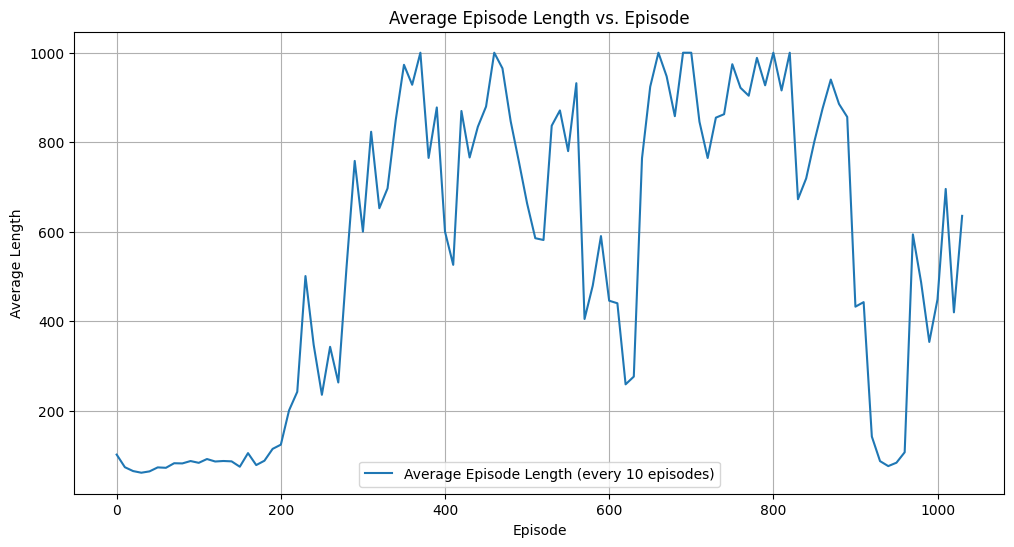

In [ ]:
mean_episodes = range(0, len(rewards), 10)
# Calculate average length every 10 episodes
mean_lengths = []
for i in range(0, len(lengths), 10):
    mean_lengths.append(sum(lengths[i:i+10]) / len(lengths[i:i+10]))

# Plot average episode lengths
plt.figure(figsize=(12, 6))
plt.plot(mean_episodes, mean_lengths, label='Average Episode Length (every 10 episodes)', linestyle='-')
plt.xlabel('Episode')
plt.ylabel('Average Length')
plt.title('Average Episode Length vs. Episode')
plt.legend()
plt.grid(True)
plt.show()

### Exercise 3.2: Solving Cartpole and Lunar Lander with `Deep Q-Learning` (harder)

On policy Deep Reinforcement Learning tends to be **very unstable**. Write an implementation (or adapt an existing one) of `Deep Q-Learning` to solve our two environments (Cartpole and Lunar Lander). To do this you will need to implement a **Replay Buffer** and use a second, slow-moving **target Q-Network** to stabilize learning.



The threshold of Cartpole is set to an average reward of 475 for the last 10 episodes !

In [ ]:
import random
from collections import deque, namedtuple
import gym

In [ ]:


class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float()

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)


def dqn(env, n_episodes=2000, max_t=1000, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995,
        buffer_size=100000, batch_size=64, tau=1e-3, lr=5e-4, update_every=4):

    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    qnetwork_local = QNetwork(input_dim, output_dim)
    qnetwork_target = QNetwork(input_dim, output_dim)
    optimizer = optim.Adam(qnetwork_local.parameters(), lr=lr)

    replay_buffer = ReplayBuffer(buffer_size, batch_size)
    epsilon = epsilon_start

    scores = []
    scores_window = deque(maxlen=10)
    length_window = deque(maxlen=10)
    episode_stats = []  # List to store episode stats

    for episode in range(1, n_episodes + 1):
        state = env.reset()
        score = 0
        episode_length = 0

        for t in range(max_t):
            state_tensor = torch.from_numpy(state).float().unsqueeze(0)
            q_values = qnetwork_local(state_tensor)
            action = select_action(q_values, epsilon, output_dim)

            next_state, reward, done, _ = env.step(action)
            replay_buffer.add(state, action, reward, next_state, done)

            state = next_state
            score += reward
            episode_length += 1

            if done:
                break

            if len(replay_buffer) > batch_size:
                experiences = replay_buffer.sample()
                learn(qnetwork_local, qnetwork_target, optimizer, experiences, gamma, tau)

        scores_window.append(score)
        length_window.append(episode_length)
        scores.append(score)

        # Store episode stats
        episode_stats.append((episode, score, episode_length))

        epsilon = max(epsilon_end, epsilon_decay * epsilon)

        if episode % 10 == 0:
            print(f"Episode {episode}\tAverage Reward: {np.mean(scores_window)}\tAverage Length: {np.mean(length_window)}\tEpsilon: {epsilon}")

        if np.mean(scores_window) >= env.spec.reward_threshold:
            print(f"Environment solved in {episode} episodes!\tAverage Reward: {np.mean(scores_window)} in the last 10 episodes")
            break

    return scores, episode_stats

def select_action(q_values, epsilon, action_size):
    if random.random() > epsilon:
        return np.argmax(q_values.cpu().data.numpy())
    else:
        return random.choice(np.arange(action_size))

def learn(qnetwork_local, qnetwork_target, optimizer, experiences, gamma, tau):
    states, actions, rewards, next_states, dones = experiences

    q_targets_next = qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
    q_targets = rewards + (gamma * q_targets_next * (1 - dones))

    q_expected = qnetwork_local(states).gather(1, actions)

    loss = F.mse_loss(q_expected, q_targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Update target network
    for target_param, local_param in zip(qnetwork_target.parameters(), qnetwork_local.parameters()):
        target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)




In [ ]:
# Train the DQN on CartPole-v0
env = gym.make('CartPole-v1')
# set seed
seed = 31
env.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
scores, episode_stats = dqn(env)
env.close()


Episode 10	Average Reward: 20.2	Average Length: 20.2	Epsilon: 0.9511101304657719
Episode 20	Average Reward: 20.5	Average Length: 20.5	Epsilon: 0.9046104802746175
Episode 30	Average Reward: 17.4	Average Length: 17.4	Epsilon: 0.8603841919146962
Episode 40	Average Reward: 21.6	Average Length: 21.6	Epsilon: 0.8183201210226743
Episode 50	Average Reward: 20.8	Average Length: 20.8	Epsilon: 0.778312557068642
Episode 60	Average Reward: 22.6	Average Length: 22.6	Epsilon: 0.7402609576967045
Episode 70	Average Reward: 16.2	Average Length: 16.2	Epsilon: 0.7040696960536299
Episode 80	Average Reward: 26.5	Average Length: 26.5	Epsilon: 0.6696478204705644
Episode 90	Average Reward: 20.6	Average Length: 20.6	Epsilon: 0.6369088258938781
Episode 100	Average Reward: 26.2	Average Length: 26.2	Epsilon: 0.6057704364907278
Episode 110	Average Reward: 31.9	Average Length: 31.9	Epsilon: 0.5761543988830038
Episode 120	Average Reward: 18.2	Average Length: 18.2	Epsilon: 0.547986285490042
Episode 130	Average Reward:

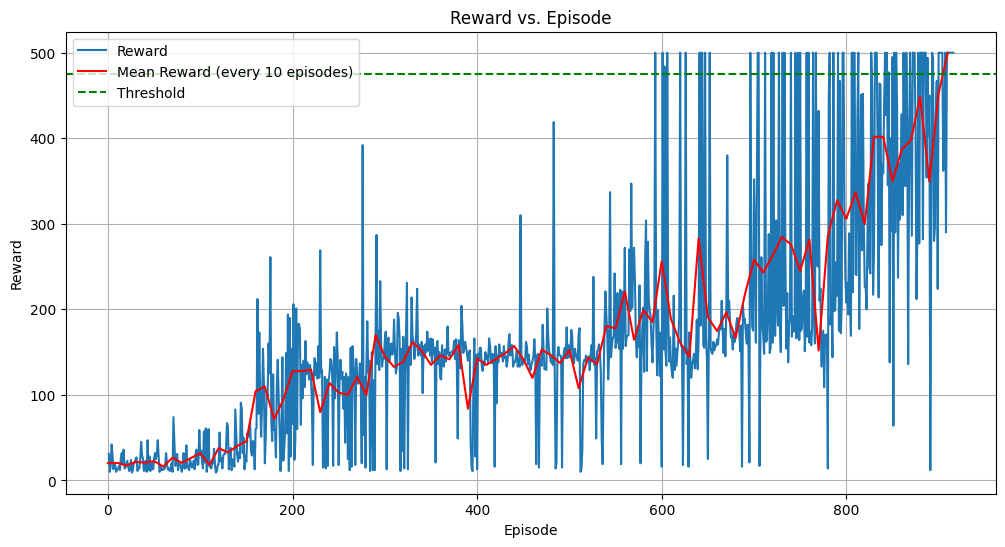

In [ ]:
# Plot rewards
episodes, rewards, lengths = zip(*episode_stats)



# Calculate mean reward every 10 episodes
mean_rewards = []
for i in range(0, len(rewards), 10):
    mean_rewards.append(sum(rewards[i:i+10]) / len(rewards[i:i+10]))

mean_episodes = range(0, len(rewards), 10)


# Plot rewards with mean reward and threshold

plt.figure(figsize=(12, 6))
plt.plot(episodes, rewards, label='Reward')
plt.plot(mean_episodes, mean_rewards, label='Mean Reward (every 10 episodes)', color='red', linestyle='-')
plt.axhline(y=env.spec.reward_threshold, color='green', linestyle='--', label='Threshold')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward vs. Episode')
plt.legend()
plt.grid(True)
plt.show()



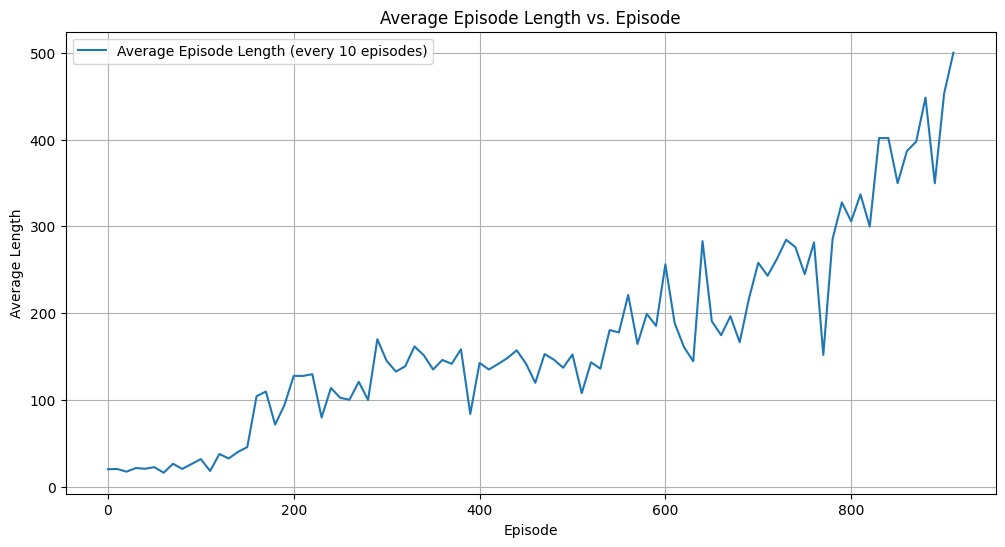

In [ ]:
mean_episodes = range(0, len(rewards), 10)
# Calculate average length every 10 episodes
mean_lengths = []
for i in range(0, len(lengths), 10):
    mean_lengths.append(sum(lengths[i:i+10]) / len(lengths[i:i+10]))

# Plot average episode lengths
plt.figure(figsize=(12, 6))
plt.plot(mean_episodes, mean_lengths, label='Average Episode Length (every 10 episodes)', linestyle='-')
plt.xlabel('Episode')
plt.ylabel('Average Length')
plt.title('Average Episode Length vs. Episode')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

# Train the DQN on LunarLander-v2
env = gym.make('LunarLander-v2')

# set seed
seed = 31
env.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

scores, episode_stats = dqn(env)
env.close()


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


Episode 10	Average Reward: -205.7689549818546	Average Length: 102.4	Epsilon: 0.9511101304657719
Episode 20	Average Reward: -135.13128666844577	Average Length: 86.9	Epsilon: 0.9046104802746175
Episode 30	Average Reward: -164.9530729773199	Average Length: 103.5	Epsilon: 0.8603841919146962
Episode 40	Average Reward: -178.38614041339554	Average Length: 117.3	Epsilon: 0.8183201210226743
Episode 50	Average Reward: -112.1353147103101	Average Length: 111.5	Epsilon: 0.778312557068642
Episode 60	Average Reward: -186.68146031088003	Average Length: 127.9	Epsilon: 0.7402609576967045
Episode 70	Average Reward: -161.1367942674581	Average Length: 119.6	Epsilon: 0.7040696960536299
Episode 80	Average Reward: -106.69390597883405	Average Length: 118.6	Epsilon: 0.6696478204705644
Episode 90	Average Reward: -138.3865953743548	Average Length: 132.4	Epsilon: 0.6369088258938781
Episode 100	Average Reward: -85.78357760670315	Average Length: 135.4	Epsilon: 0.6057704364907278
Episode 110	Average Reward: -83.84314

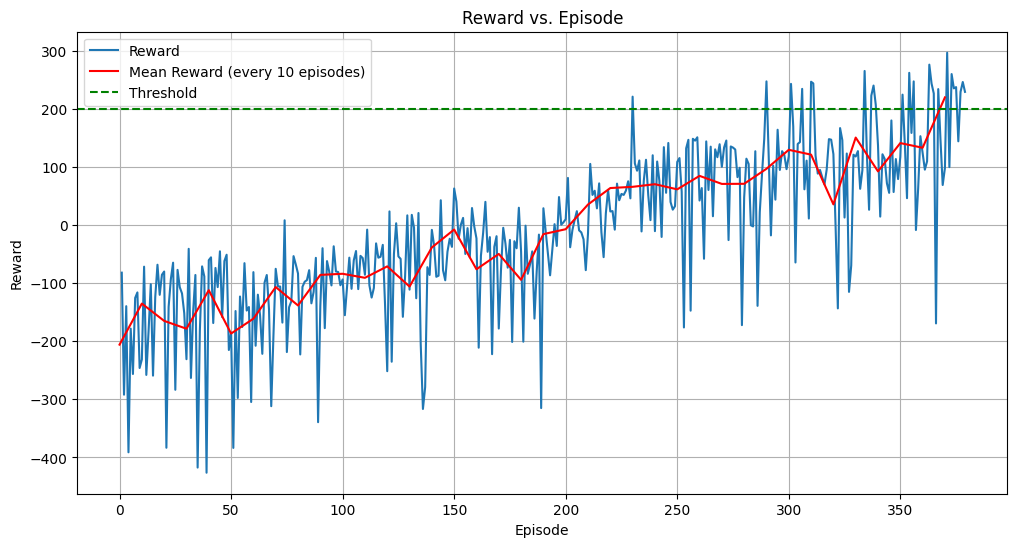

In [ ]:
# Plot rewards
episodes, rewards, lengths = zip(*episode_stats)



# Calculate mean reward every 10 episodes
mean_rewards = []
for i in range(0, len(rewards), 10):
    mean_rewards.append(sum(rewards[i:i+10]) / len(rewards[i:i+10]))

mean_episodes = range(0, len(rewards), 10)


# Plot rewards with mean reward and threshold

plt.figure(figsize=(12, 6))
plt.plot(episodes, rewards, label='Reward')
plt.plot(mean_episodes, mean_rewards, label='Mean Reward (every 10 episodes)', color='red', linestyle='-')
plt.axhline(y=env.spec.reward_threshold, color='green', linestyle='--', label='Threshold')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward vs. Episode')
plt.legend()
plt.grid(True)
plt.show()


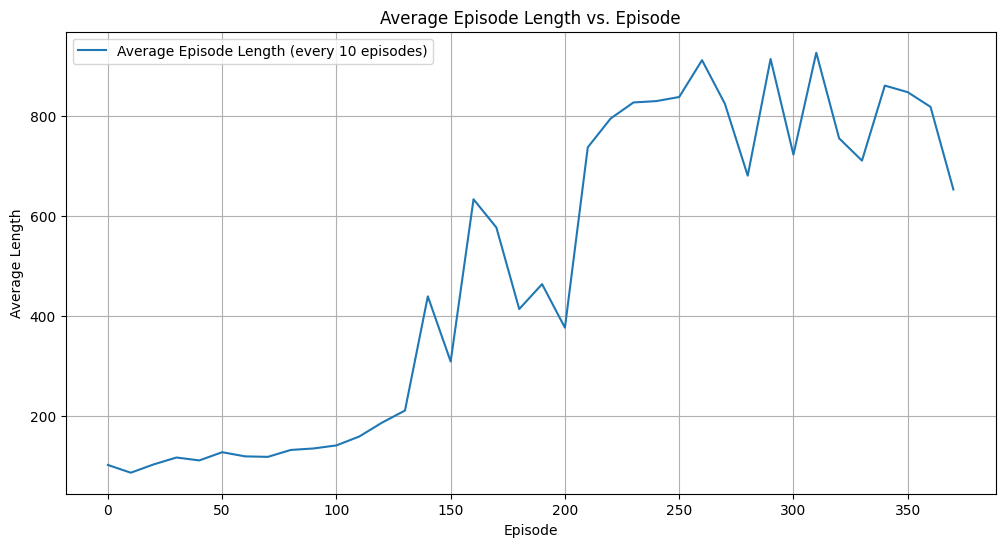

In [ ]:
mean_episodes = range(0, len(rewards), 10)
# Calculate average length every 10 episodes
mean_lengths = []
for i in range(0, len(lengths), 10):
    mean_lengths.append(sum(lengths[i:i+10]) / len(lengths[i:i+10]))

# Plot average episode lengths
plt.figure(figsize=(12, 6))
plt.plot(mean_episodes, mean_lengths, label='Average Episode Length (every 10 episodes)', linestyle='-')
plt.xlabel('Episode')
plt.ylabel('Average Length')
plt.title('Average Episode Length vs. Episode')
plt.legend()
plt.grid(True)
plt.show()

Both environments were successfully solved using the DQN approach with the provided architecture and hyperparameters. The results indicate that the models learned effective policies for both the CartPole and Lunar Lander environments.

* CartPole: Achieved an average reward of **479.0** in the last 10 episodes, solving the environment in **916 episodes**.
* Lunar Lander: Achieved an average reward of **207.54** in the last 10 episodes, solving the environment in **379 episodes**.

### Exercise 3.3: Solving the OpenAI CarRacing environment (hardest)

Use `Deep Q-Learning` -- or even better, an off-the-shelf implementation of **Proximal Policy Optimization (PPO)** -- to train an agent to solve the [OpenAI CarRacing](https://github.com/andywu0913/OpenAI-GYM-CarRacing-DQN) environment. This will be the most *fun*, but also the most *difficult*. Some tips:

1. Make sure you use the `continuous=False` argument to the environment constructor. This ensures that the action space is **discrete** (we haven't seen how to work with continuous action spaces).
2. Your Q-Network will need to be a CNN. A simple one should do, with two convolutional + maxpool layers, folowed by a two dense layers. You will **definitely** want to use a GPU to train your agents.
3. The observation space of the environment is a single **color image** (a single frame of the game). Most implementations stack multiple frames (e.g. 3) after converting them to grayscale images as an observation.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!apt-get install swig


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 45 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 2s (523 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 123586 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubunt

In [ ]:
!pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 15.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 85.3 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2349118 sha256=5490940b10651aff25778bc7a27f8d9ea173829bc4b3a4683658f07ef1c51e03
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [ ]:
!pip install gymnasium

In [ ]:
pip install stable-baselines3[extra] shimmy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 4.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of shimmy to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 15.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-p

In [ ]:
import gymnasium as gym
import numpy as np
import cv2
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import torch as th
import torch.nn as nn


In [ ]:

# Define Custom CNN
class CustomCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 256):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten()
        )
        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(th.as_tensor(observation_space.sample()[None]).float()).shape[1]
        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))

def preprocess_observation(obs):
    obs_gray = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
    obs_resized = cv2.resize(obs_gray, (96, 96), interpolation=cv2.INTER_AREA)
    return obs_resized

class PreprocessObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super(PreprocessObservationWrapper, self).__init__(env)
        self.observation_space = gym.spaces.Box(
            low=0, high=255, shape=(1, 96, 96), dtype=np.uint8
        )

    def observation(self, obs):
        return np.expand_dims(preprocess_observation(obs), axis=0)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Make environment and wrap it
env_id = 'CarRacing-v2'
env = make_vec_env(env_id, n_envs=1, wrapper_class=PreprocessObservationWrapper)
env = VecFrameStack(env, n_stack=3)

# Define the policy with our custom CNN
policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=256),
)

# Create the PPO agent
model = PPO('CnnPolicy', env, policy_kwargs=policy_kwargs, verbose=1, tensorboard_log="./ppo_carracing_tensorboard/")

# Evaluation callback to monitor training
eval_callback = EvalCallback(env, best_model_save_path='/content/drive/MyDrive/PPO_CarRacing/',
                             log_path='/content/drive/MyDrive/PPO_CarRacing/logs/', eval_freq=500,
                             deterministic=True, render=False)

# Checkpoint callback to save models periodically
checkpoint_callback = CheckpointCallback(save_freq=1000, save_path='/content/drive/MyDrive/PPO_CarRacing/checkpoints/',
                                         name_prefix='ppo_model')

# Train the agent
model.learn(total_timesteps=1000000, callback=[eval_callback, checkpoint_callback])

# Save the trained model
model.save("/content/drive/MyDrive/PPO_CarRacing/ppo_carracing")



Using cuda device
Logging to ./ppo_carracing_tensorboard/PPO_1
Eval num_timesteps=500, episode_reward=-25.30 +/- 7.01
Episode length: 1000.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -25.3    |
| time/              |          |
|    total_timesteps | 500      |
---------------------------------
New best mean reward!
Eval num_timesteps=1000, episode_reward=-24.24 +/- 6.78
Episode length: 1000.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -24.2    |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------
New best mean reward!
Eval num_timesteps=1500, episode_reward=-25.43 +/- 5.93
Episode length: 1000.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -25.4    |
| time/        

## I STOPPED THE TRAINING DUE TO THE LACK OF GPU!

In [ ]:
# Load the PPO agent
model = PPO('CnnPolicy', env, policy_kwargs=policy_kwargs, verbose=1, tensorboard_log="./ppo_carracing_tensorboard/")
model.load("/content/drive/MyDrive/PPO_CarRacing/ppo_carracing")

# Evaluation callback to monitor training
eval_callback = EvalCallback(env, best_model_save_path='/content/drive/MyDrive/PPO_CarRacing/',
                             log_path='/content/drive/MyDrive/PPO_CarRacing/logs/', eval_freq=500,
                             deterministic=True, render=False)

# Checkpoint callback to save models periodically
checkpoint_callback = CheckpointCallback(save_freq=1000, save_path='/content/drive/MyDrive/PPO_CarRacing/checkpoints/',
                                         name_prefix='ppo_model')

# Continue training the agent
model.learn(total_timesteps=1000000, callback=[eval_callback, checkpoint_callback])

# Save the trained model again
model.save("/content/drive/MyDrive/PPO_CarRacing/ppo_carracing")

In [ ]:
#Monitor Training with TensorBoard

%load_ext tensorboard
%tensorboard --logdir ./ppo_carracing_tensorboard/


In [ ]:
# Load the trained model
model = PPO.load("/content/drive/MyDrive/PPO_CarRacing/ppo_carracing")

# Test the trained model
obs = env.reset()
for _ in range(1000):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    env.render()
    if done:
        obs = env.reset()
env.close()
